# Tree Based Methods for TKN Prediction in Influent Wastewater

Model Iteration No. 2 - This code uses top 3 SHAP values as project feature inputs (P-TOT, CBOD5, VTS). See Appendix F for SHAP value analysis conducted in Model Iteration 1.

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

# For random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

# For gradient boosting 
from xgboost import XGBRegressor

# For evaluation 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# For hyperparameter tuning
import optuna
import sklearn

In [125]:
# For training data split
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# Import the Data

In [299]:
influent_data = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent_data

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183
...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070


# Prepare the Training Data

See top 3 project input features used here.

In [300]:
# Prepare the training set
X = influent_data[['P-TOT','CBOD5','VTS']]
Y = influent_data[['TKN']]
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
 test_size = 0.2, random_state=0, shuffle=False)

In [301]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()
X_train_df = (X_train_df - mean_x)/std_x
X_test_df = (X_test_df - mean_x)/std_x
Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df = (Y_test_df - mean_y)/std_y
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 3) (3506, 1)
(877, 3) (877, 1)


# Random Forest Regression Model

Set Hyperparameters and Model Architecture
​

In [302]:
# RFR MODEL
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':752,
              'criterion':'squared_error', 
              'max_depth': 7,         
              'min_samples_leaf':3,
              'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}

Evaluate the Model

In [303]:
rf_model = RandomForestRegressor(**params_rfr)
rf_model

RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=752)

In [304]:
%%time
history = rf_model.fit(X_train, Y_train)

<timed exec>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: total: 6.31 s
Wall time: 6.68 s


Make Predictions

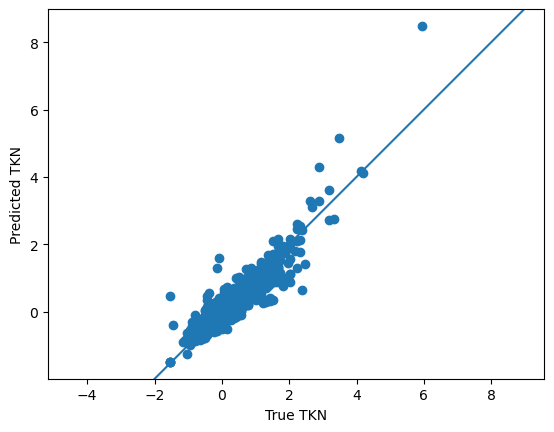

In [305]:
test_predictions = rf_model.predict(X_test)

plt.scatter(Y_test, test_predictions)
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [306]:
mse = mean_squared_error(Y_test, test_predictions)
print('The mse is:', mse)

The mse is: 0.11207768525448054


In [307]:
# Print out the prediction scores
print('MSE: {}'.format(mean_squared_error(Y_test, test_predictions)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(Y_test, test_predictions))))
print('MAE: {}'.format(mean_absolute_error(Y_test, test_predictions)))
print('R-SQ: {}'.format(r2_score(Y_test, test_predictions)))

MSE: 0.11207768525448054
RMSE: 0.33478005504283037
MAE: 0.23391937055785425
R-SQ: 0.8431597426219906


Use Optuna tool to refine hyperparameters

Code source: https://www.analyticsvidhya.com/blog/2020/11/hyperparameter-tuning-using-optuna/

In [135]:
def objective(trial):
      n_estimators = trial.suggest_int('n_estimators', 2, 2000)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 40))
      rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
      return sklearn.model_selection.cross_val_score(rf_model, X_train, Y_train, 
           n_jobs=-1, cv=3).mean()

In [136]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-12-23 01:38:10,772] A new study created in memory with name: no-name-218d9d1b-e472-4090-92c7-78376f448755
[I 2022-12-23 01:38:17,879] Trial 0 finished with value: 0.3195522198141467 and parameters: {'n_estimators': 503, 'max_depth': 7.679442967957044}. Best is trial 0 with value: 0.3195522198141467.
[I 2022-12-23 01:38:20,516] Trial 1 finished with value: -0.023167684378562092 and parameters: {'n_estimators': 327, 'max_depth': 1.9958266808530807}. Best is trial 0 with value: 0.3195522198141467.
[I 2022-12-23 01:38:34,208] Trial 2 finished with value: 0.29299880573885206 and parameters: {'n_estimators': 761, 'max_depth': 19.873442174561816}. Best is trial 0 with value: 0.3195522198141467.
[I 2022-12-23 01:38:58,188] Trial 3 finished with value: 0.2694871099206089 and parameters: {'n_estimators': 1484, 'max_depth': 35.76726503686333}. Best is trial 0 with value: 0.3195522198141467.
[I 2022-12-23 01:39:06,875] Trial 4 finished with value: 0.32415724551055164 and parameters: {'n_es

[I 2022-12-23 01:44:43,111] Trial 39 finished with value: 0.32303760814878185 and parameters: {'n_estimators': 1083, 'max_depth': 5.999874856780024}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:44:45,368] Trial 40 finished with value: 0.2630979744050091 and parameters: {'n_estimators': 161, 'max_depth': 18.350306817692218}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:44:54,184] Trial 41 finished with value: 0.30941522032299124 and parameters: {'n_estimators': 1076, 'max_depth': 6.610000174197313}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:45:04,474] Trial 42 finished with value: 0.30913489552011303 and parameters: {'n_estimators': 1411, 'max_depth': 5.690399691513061}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:45:10,219] Trial 43 finished with value: 0.2793769165291495 and parameters: {'n_estimators': 902, 'max_depth': 4.10337524498765}. Best is trial 24 with value: 0.33387427627930205.
[I 2

[I 2022-12-23 01:49:45,717] Trial 78 finished with value: 0.30384801479769674 and parameters: {'n_estimators': 691, 'max_depth': 8.6829591761814}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:49:57,355] Trial 79 finished with value: 0.30072015112281114 and parameters: {'n_estimators': 1663, 'max_depth': 5.223782634098755}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:50:09,712] Trial 80 finished with value: 0.2737535483768571 and parameters: {'n_estimators': 1926, 'max_depth': 4.3081910856729015}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:50:13,974] Trial 81 finished with value: 0.2705101168785115 and parameters: {'n_estimators': 493, 'max_depth': 7.092348284753709}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12-23 01:50:14,772] Trial 82 finished with value: 0.328326748908831 and parameters: {'n_estimators': 98, 'max_depth': 6.11843567565944}. Best is trial 24 with value: 0.33387427627930205.
[I 2022-12

In [137]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.3413814886606681


Include the following parameters in the model above: 

In [138]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'n_estimators': 752, 'max_depth': 6.507149323546237}


# XGB Gradient Boosting

Set Hyperparameters and Model Architecture​

In [308]:
# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              'n_estimators': 100,  # number of trees 
              'learning_rate': 0.15, 
              'max_depth': 3,       # levels in each tree
              'reg_alpha': 1,
              'reg_lambda': 0,}

Evaluate the Model

In [309]:
xgb_model = XGBRegressor(**params_xgb)

In [310]:
%%time
xgb_model.fit(X_train, Y_train)

CPU times: total: 1.55 s
Wall time: 213 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, ...)

Make Predictions

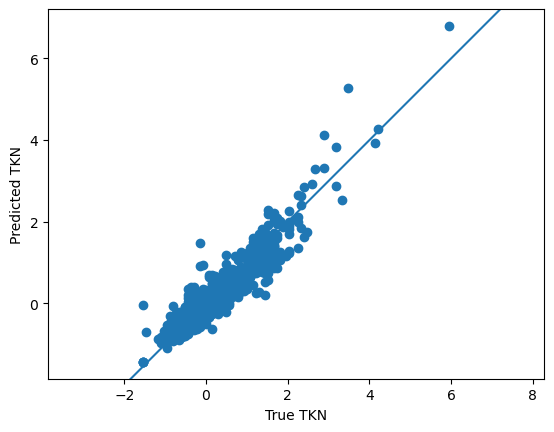

In [311]:
test_predict_XG = xgb_model.predict(X_test)

plt.scatter(Y_test, test_predict_XG)
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [312]:
mse = mean_squared_error(Y_test, test_predict_XG)
mse

0.09654628276497093

In [313]:
# print out the prediction scores
print('MSE: {}'.format(mean_squared_error(Y_test, test_predict_XG)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(Y_test, test_predict_XG))))
print('MAE: {}'.format(mean_absolute_error(Y_test, test_predict_XG)))
print('R-SQ: {}'.format(r2_score(Y_test, test_predict_XG)))

MSE: 0.09654628276497093
RMSE: 0.31071897715616104
MAE: 0.22973763859461496
R-SQ: 0.8648942133006555
